In [1]:
!pip install fdasrsf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 16.2 MB/s eta 0:00:00


In [2]:
import random

In [3]:
import numpy as np

def interpolate_function(original_t, f_values, new_points):
    """
    Interpolate f_values at new_points using linear interpolation over the original time grid.

    Args:
        original_t (np.ndarray): 1D array of original time grid for f values (must be sorted).
        f_values (np.ndarray): 1D array of values of f at original_t.
        new_points (np.ndarray): 1D array of points at which to evaluate interpolated f values.

    Returns:
        np.ndarray: Interpolated f_values at new_points.
    """
    # Find indices where each new_point would be inserted to maintain order
    lower_indices = np.searchsorted(original_t, new_points, side='right') - 1
    lower_indices = np.clip(lower_indices, 0, len(original_t) - 2)

    # Get lower and upper bounds for interpolation
    t_lower = original_t[lower_indices]
    t_upper = original_t[lower_indices + 1]
    f_lower = f_values[lower_indices]
    f_upper = f_values[lower_indices + 1]

    # Compute linear interpolation weights
    weights = (new_points - t_lower) / (t_upper - t_lower)

    # Interpolate
    interpolated_values = f_lower + weights * (f_upper - f_lower)

    return interpolated_values


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from fdasrsf.utility_functions import *
from fdasrsf.fPLS import *
import fdasrsf as fs
import fdasrsf.utility_functions as uf
# Set the global font size
plt.rcParams.update({'font.size': 15})  #

# Define your functions fn, gamma, srsf, and srsf_to_beta if they are custom
# For example:
def fn(t):
    # Parameters for the bell curve
    mu = 50        # Center of the bell (midpoint of 0 to 100)
    sigma = 15     # Standard deviation (controls width of the bell)

    bell_curve = np.exp(-0.5 * ((t - mu) / sigma) ** 2)
    return bell_curve


def gamma(t):
    power = np.random.uniform(1, 3)

    if np.random.randint(0, 2) == 0:
        power = 1.0 / power

    return np.power(t, power)


t1 = np.linspace(0, 100, 50)
t2 = np.linspace(0, 1, 50)

amplitude = fn(t1)
warp = gamma(t2)
phase_amplitude = uf.warp_f_gamma(t2, amplitude, warp)

reflected_time_points = warp  # New x-values
reflected_function_values = t2  # New y-values

In [49]:
gamma_inv = uf.invertGamma(warp)
beta2_inv = uf.warp_f_gamma(t2, phase_amplitude, gamma_inv)

# Interpolate to t1 domain
from scipy.interpolate import interp1d
interp_func = interp1d(t2 * 100, beta2_inv, kind='linear', bounds_error=False, fill_value="extrapolate")
beta2_inv_interp = interp_func(t1)

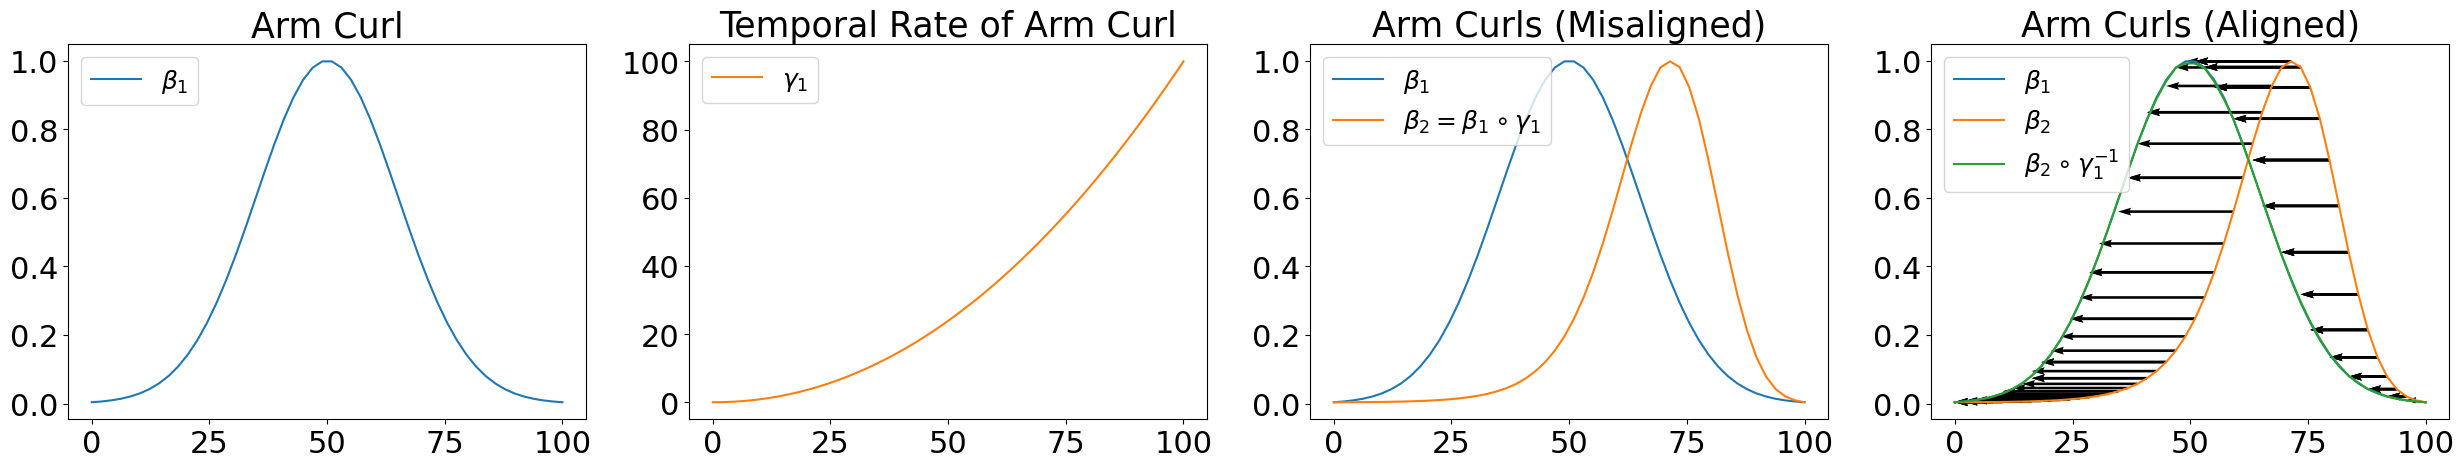

In [136]:
# plt.rcParams.update({'font.size': 17})  #
# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(25, 5), sharey='col')
fig.set_rasterized(True)

axs[0].plot(t1, amplitude, label=r'$\beta_1$',color='tab:blue')
axs[1].plot(t1, warp * 100, label=r'$\gamma_1$',color='tab:orange')
axs[2].plot(t1, amplitude, label=r'$\beta_1$',color='tab:blue')
axs[2].plot(t1, phase_amplitude, label=r'$\beta_2 = \beta_1 \circ \gamma_1$',color='tab:orange')
axs[3].plot(t1, amplitude, label=r'$\beta_1$',color='tab:blue')
axs[3].plot(t1, phase_amplitude, label=r'$\beta_2$',color='tab:orange')
axs[3].plot(t1, beta2_inv_interp, label=r'$\beta_2 \circ \gamma_1^{-1}$', color='tab:green')


# Add horizontal quivers for 50 corresponding points in the 4th subplot
n_points = 50
# Select evenly spaced indices
indices1 = np.linspace(0, np.argmax(phase_amplitude), n_points, dtype=int)

ps1 = phase_amplitude
beta2_inv1 = beta2_inv_interp[0:25]

for i in indices1:
    y_level = ps1[i]  # Use orange curve y-value as reference
    x_orange = t1[i]  # x-position on orange curve

    # Find corresponding x-position on green curve at same y-level
    # Find closest y-value in green curve
    closest_idx = np.argmin(np.abs(beta2_inv1 - y_level))
    x_green = t1[closest_idx]

    dx = x_green-x_orange  # Horizontal displacement
    dy = 0  # No vertical displacement for horizontal quivers

    # Add quivers to the 4th subplot
    axs[3].quiver(x_orange, y_level, dx, dy,
              angles='xy', scale_units='xy', scale=1,
              color='black', width=0.005)



# Second half - from peak to end
indices2 = np.linspace(np.argmax(phase_amplitude), len(phase_amplitude)-1, n_points, dtype=int)
ps2 = phase_amplitude
beta2_inv2 = beta2_inv_interp[25:]  # Second half of green curve

for i in indices2:
    y_level = ps2[i]  # Use orange curve y-value as reference
    x_orange = t1[i]  # x-position on orange curve

    # Find corresponding x-position on green curve at same y-level
    # Find closest y-value in green curve (second half)
    closest_idx = np.argmin(np.abs(beta2_inv2 - y_level))
    x_green = t1[25 + closest_idx]  # Offset by 25 to get correct t1 index

    dx = x_green - x_orange  # Horizontal displacement
    dy = 0  # No vertical displacement for horizontal quivers

    # Add quivers to the 4th subplot
    axs[3].quiver(x_orange, y_level, dx, dy,
              angles='xy', scale_units='xy', scale=1,
              color='black', width=0.005)




axs[0].set_title('Arm Curl',fontsize=25)
axs[1].set_title('Temporal Rate of Arm Curl',fontsize=25)
axs[2].set_title('Arm Curls (Misaligned)',fontsize=25)
axs[3].set_title('Arm Curls (Aligned)',fontsize=25)



# Show legends for all subplots
for ax in axs:
    ax.legend(loc='upper left',fontsize=18)
    ax.tick_params(axis='x', which='major', labelsize=22)
    ax.tick_params(axis='y', which='major', labelsize=22)

plt.tight_layout()
plt.savefig('Fig_2.eps',bbox_inches='tight')